In [22]:
from model import load_model
from image_utils import imagenet_utils
import cv2 ,matplotlib.pyplot as plt
import numpy as np

In [23]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:

# orig_img,img=imagenet_utils.load_test_img("both.png")
orig_img,img=imagenet_utils.load_test_img("ILSVRC2012_img_val/ILSVRC2012_val_00000111.JPEG")  # crab

In [3]:
test=load_model('VGG16')

In [5]:
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'

In [6]:
# Fredriks stuff, remove if not needed
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [7]:

from explanation_models import gradcam,gradcam_robust,gradcam_plusplus,guided_backprop

# GradCAM

In [8]:
import tensorflow as tf
print(tf.keras.applications.vgg16.decode_predictions(model.predict(img), top=5))

[[('n01983481', 'American_lobster', 0.5665773), ('n07615774', 'ice_lolly', 0.14764345), ('n01985128', 'crayfish', 0.03405892), ('n01978287', 'Dungeness_crab', 0.030875813), ('n07697537', 'hotdog', 0.027299289)]]


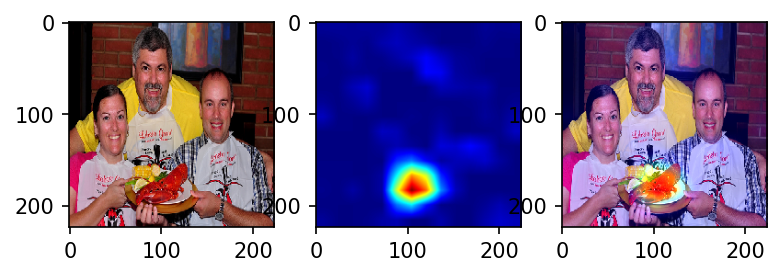

In [9]:
g= gradcam(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
heatmap_colormap,overlayed_img_origgp=imagenet_utils.overlay_heatmap(orig_img,heatmap)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img_origgp)

# GradCAM Robust - average

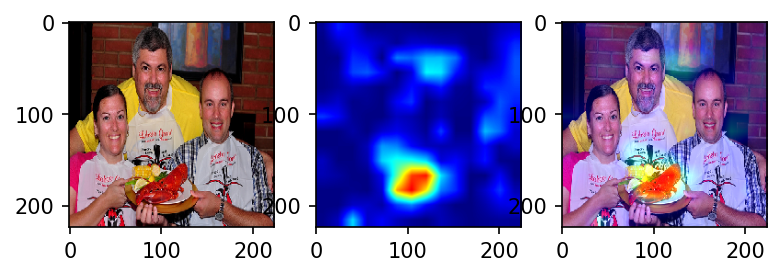

In [10]:
layers=['block5_conv1','block5_conv2','block5_conv3']
g_robust= gradcam_robust(model,layers,input_dim,'GradCAM')
heatmap=g_robust.get_heatmap(img)
final=(heatmap[0]+heatmap[1]+heatmap[2])/3.0
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM Robust - max

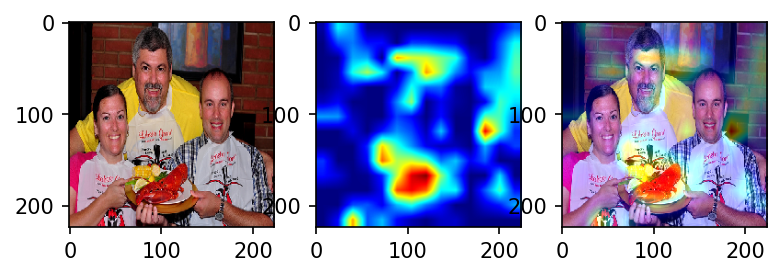

In [11]:
import tensorflow as tf
final=tf.math.maximum(heatmap[0],heatmap[1],heatmap[2])
heatmap_colormap,overlayed_img=imagenet_utils.overlay_heatmap(orig_img,final)
f, axarr = plt.subplots(1,3)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img)

# GradCAM++

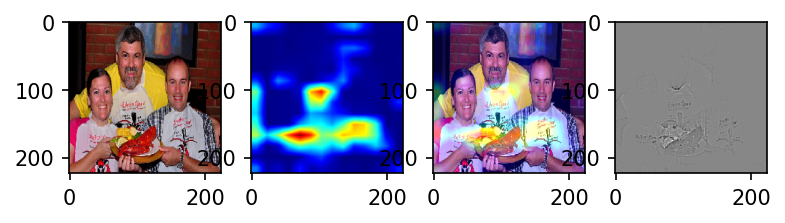

In [17]:
g1 = guided_backprop(model,layer_name,input_dim)
guided_bp=g1.get_heatmap(img)

g= gradcam_plusplus(model,layer_name,input_dim)
heatmap=g.get_heatmap(img)
# heatmap_colormap,overlayed_img_gcpp=imagenet_utils.overlay_heatmap(orig_img,heatmap)

heatmap_colormap, combined_gcpp =imagenet_utils.combine_guided_bp(orig_img, heatmap, guided_bp)

f, axarr = plt.subplots(1,4)
axarr[0].imshow(orig_img)
axarr[1].imshow(heatmap_colormap)
axarr[2].imshow(overlayed_img_gcpp)
axarr[3].imshow(combined_gcpp, cmap=plt.cm.gray)


# Guided Backprop + GradCAM

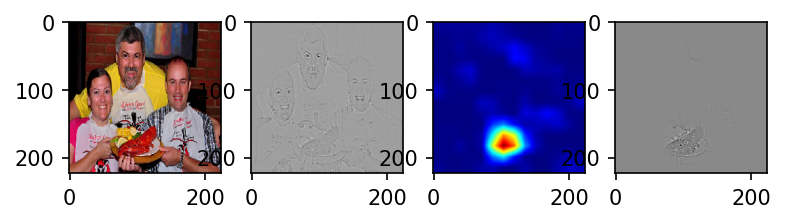

In [15]:
g1 = guided_backprop(model,layer_name,input_dim)
guided_bp=g1.get_heatmap(img)

g2 = gradcam(model,layer_name,input_dim)
heatmap=g2.get_heatmap(img)

heatmap_colormap, combined_gc =imagenet_utils.combine_guided_bp(orig_img, heatmap, guided_bp)

f, axarr = plt.subplots(1,4)
axarr[0].imshow(orig_img)
axarr[1].imshow(guided_bp, cmap=plt.cm.gray)
axarr[2].imshow(heatmap_colormap)
axarr[3].imshow(combined_gc, cmap=plt.cm.gray)

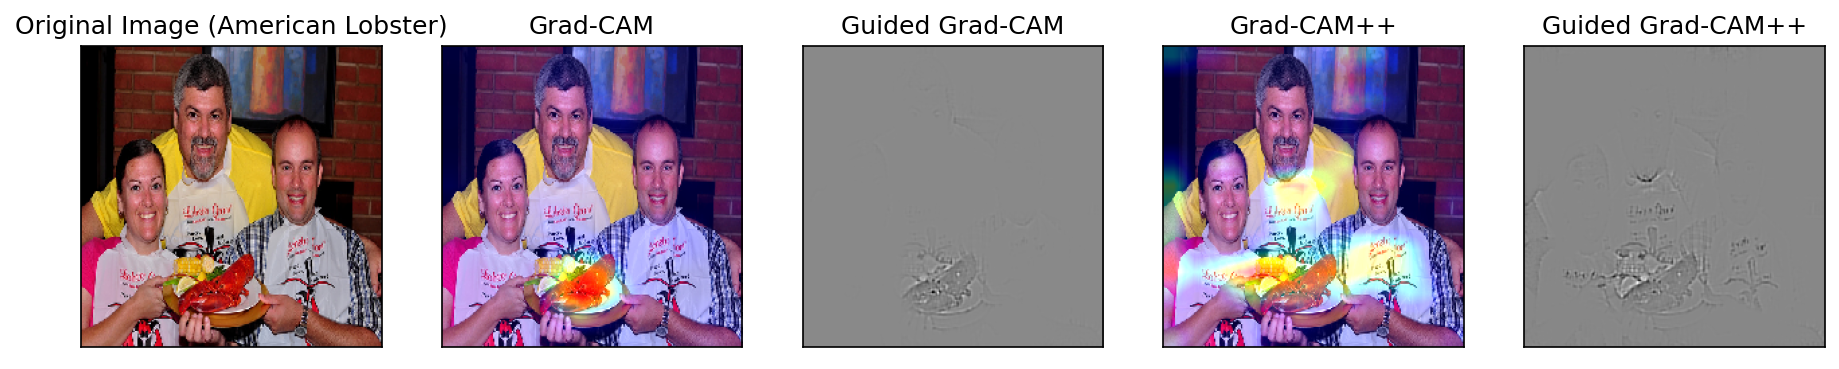

In [21]:
f, axarr = plt.subplots(1,5)
f = plt.gcf()
f.set_size_inches(15,8)
for ax in axarr:
    ax.set_xticks([])
    ax.set_yticks([])
axarr[0].imshow(orig_img)
axarr[0].title.set_text('Original Image (American Lobster)')
axarr[1].imshow(overlayed_img_origgp)
axarr[1].title.set_text('Grad-CAM')
axarr[2].imshow(combined_gc,cmap=plt.cm.gray)
axarr[2].title.set_text('Guided Grad-CAM')
axarr[3].imshow(overlayed_img_gcpp)
axarr[3].title.set_text('Grad-CAM++')
axarr[4].imshow(combined_gcpp,cmap=plt.cm.gray)
axarr[4].title.set_text('Guided Grad-CAM++')

plt.savefig('Results/GC_GCP_2.jpeg', dpi=200)